# Profit Maximization

Here we will try to optimize expected bet win based on each driver success probability and bookmaker's success coefficients.

In [1]:
import matplotlib.pyplot as plt
from itertools import combinations, permutations, product, chain
import numpy as np
import gc, csv

%matplotlib inline

In [2]:
'''
Function for Sharpe ration calculation for various number of drivers in one calculation

Input is 
- an array of possibilities for all the drivers to score
- an array of money stakes for each driver (generates later to gen a distribution)
- an array of bookmaker coefficients for each driver

The dimentions obviously should be the same and equal to number on drivers in a run

'''

def sharpe(pos, mon, koef):

    p_temp = []
    m_temp = []
    k_temp = []
    
    # Calculating a list of possible intersections for each instance
    for i in range(len(pos)):
        p_temp.append([pos[i], 1 - pos[i]])
        m_temp.append([mon[i], mon[i] - mon[i]])
        k_temp.append([koef[i], koef[i] - koef[i]])

    # Generating all the combinations
    p = list(product(*p_temp))
    m = list(product(*m_temp))
    k = list(product(*k_temp))

    # Calculating probabilities for each income
    p_list = []
    for i in range(len(p)):
        p_item = p[i][0]
        for j in range(1, len(p[0])):
            p_item *= p[i][j]
        p_list.append(p_item)

    # Overall stake sum
    cost = sum(mon)

    # Profit weighted with probability for each income
    prof = []
    for i in range(len(p)):
        prof.append(sum([(m[i][j] * k[i][j]) for j in range(len(m[i]))]) - cost)

    # Mean expectation
    mex = sum([pr * p for pr, p in zip(prof, p_list)])

    # Dispersion
    disp = 0
    for i in range(len(p)):
        disp += (len(mon) / (len(mon) - 1)) * p_list[i] * (prof[i] - mex) ** 2

    # Returning Sharpe ratio
    return mex / disp

In [4]:
# Function generates sample for money distribution. Input is number of drivers in a run

def money_generator(n):

    line = np.linspace(0, 1, 11)
    lines = (n) * [line]
    m = list(product(*lines))
    i = 0
    while i < len(m):
        if sum(m[i]) != 1:
            m.pop(i)
        else:
            i += 1
            
    return m

In [30]:
for n in range(2, 8):
    file_name = './Money_sets/money_set_' + str(n) + '.txt'
    with open(file_name, 'w') as file:
        writer = csv.writer(file, delimiter = ';')
        
        line = np.linspace(0, 1, 6)
        lines = (n) * [line]
        m = list(product(*lines))
        i = 0
        while i < len(m):
            if sum(m[i]) == 1:
                writer.writerow(m[i])
            i += 1
                
        print(f"{file_name} is done")

./Money_sets/money_set_2.txt is done
./Money_sets/money_set_3.txt is done
./Money_sets/money_set_4.txt is done
./Money_sets/money_set_5.txt is done
./Money_sets/money_set_6.txt is done
./Money_sets/money_set_7.txt is done


In [3]:
drivers = [['Valtteri Bottas', 1.08, 0.876858],
            ['Lewis Hamilton', 1.08, 0.881510],
            ['Sebastian Vettel', 1.1, 0.970648],
            ['Charles Leclerc', 1.2, 0.918167],
            ['Max Verstappen', 1.2, 0.875779],
            ['Pierre Gasly', 1.25, 0.536749],
            ['Daniel Ricciardo', 1.25, 0.471569],
            ['Nico Hulkenberg', 1.28, 0.412152],
            ['Kevin Magnussen', 1.67, 0.821354],
            ['Romain Grosjean', 1.83, 0.865521],
            ['Daniil Kvyat', 2, 0.361330],
            ['Sergio Perez', 3.25, 0.470427],
            ['Kimi Raikkonen', 2, 0.899139],
            ['Carlos Sainz', 2.1, 0.574008],
            ['Lando Norris', 2.5, 0.737551],
            ['Lance Stroll', 6, 0.525196],
            ['George Russell', 23, 0.020211],
            ['Robert Kubica', 23, 0.030337],
            ['Antonio Giovinazzi', 11, 0.578652],
            ['Alexander Albon', 5.5, 0.574172]]

In [4]:
def challenger(drivers):
    
    gc.collect()
    
    combs = []
    for num_drivers in [2, 3]:
        combs.append(list(combinations(drivers, num_drivers)))

    combs = list(chain(*combs))

    overall_max = [0]
    stakes_no = 0
    for run in combs:
        
        stakes_no_old = stakes_no
        stakes_no = len(run)

        if stakes_no_old != stakes_no:
            
            mon = np.genfromtxt(r'./Money_sets/money_set_' + str(len(run)) + '.txt', delimiter=';')

        pos = []
        koef = []
        driver = []

        for i in range(len(run)):
            pos.append(run[i][2])
            koef.append(run[i][1])
            driver.append(run[i][0])

        local_max = [-10]
        for m in mon:
            sh = sharpe(pos, m, koef)
            if sh > local_max[0]:
                local_max = [sh]
                local_max.append(m)
                local_max.append(driver)
        #print(f"For pair {driver} maximum profit is {round(local_max[0],2)} at money spent like {local_max[1]}")
        if local_max[0] > overall_max[0]:
            overall_max = [local_max[0]]
            overall_max.append(local_max[2])
            overall_max.append(local_max[1])

    print(f"Overall maximum is for pair {overall_max[1]} maximum profit is {round(overall_max[0],2)} at money spent like {overall_max[2]}")

In [5]:
%%time
challenger(drivers)

Overall maximum is for pair ['Sebastian Vettel', 'Romain Grosjean', 'Kimi Raikkonen'] maximum profit is 4.97 at money spent like [0.6 0.2 0.2]
Wall time: 893 ms


Let's visualize the result of stake maximization for two fixed drivers:

Sebastian Vettel:
    - Bookmaker's coefficient 1.1
    - Top-10 finish probability 0.970648
Lando Norris:
    - Bookmaker's coefficient 2.5
    - Top-10 finish probability 0.737551
Pierre Gasly:
    - Bookmaker's coefficient 1.25
    - Top-10 finish probability 0.536749

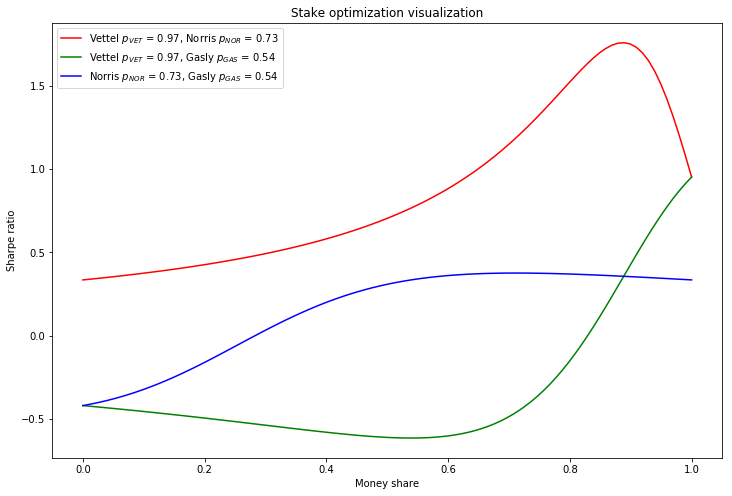

In [14]:
ns = np.linspace(0, 1, 100)
mon = []
res_vet_nor = []
res_vet_gas = []
res_nor_gas = []
for n in ns:
    res_vet_nor.append(sharpe([0.97, 0.73], [n, 1-n], [1.1, 2.5]))
    res_vet_gas.append(sharpe([0.97, 0.54], [n, 1-n], [1.1, 1.25]))
    res_nor_gas.append(sharpe([0.73, 0.54], [n, 1-n], [2.5, 1.25]))

fig = plt.figure(figsize = (12, 8))
plt.plot(ns, res_vet_nor, color = 'red', label = 'Vettel $p_{VET}$ = 0.97, Norris $p_{NOR}$ = 0.73')
plt.plot(ns, res_vet_gas, color = 'green', label = 'Vettel $p_{VET}$ = 0.97, Gasly $p_{GAS}$ = 0.54')
plt.plot(ns, res_nor_gas, color = 'blue', label = 'Norris $p_{NOR}$ = 0.73, Gasly $p_{GAS}$ = 0.54')
plt.title('Stake optimization visualization')
plt.xlabel('Money share')
plt.ylabel('Sharpe ratio')
plt.legend()
plt.show()

Not let's try to visualize not pairs of pilots, but triples

In [15]:
ns1 = np.linspace(0, 1, 100)
ns2 = []
ns3 = []
for i in range(len(ns1)):
    ns2.append(np.random.rand())
for i in range(len(ns1)):
    ns3.append(1 - ns1[i] - ns2[i])

In [17]:
import pandas as pd

df = pd.DataFrame({'n1': ns1, 'n2': ns2, 'n3': ns3})
df.head()

,n1,n2,n3
0,0.000000,0.301314,0.698686
1,0.010101,0.131035,0.858864
2,0.020202,0.772980,0.206818
3,0.030303,0.673538,0.296159
4,0.040404,0.598246,0.361350


In [77]:
res = []
for i in range(df.shape[0]):
    res.append(sharpe3d(m1 = df.iloc[i]['n1'], m2 = df.iloc[i]['n2'], m3 = df.iloc[i]['n3']))

<IPython.core.display.Javascript object>


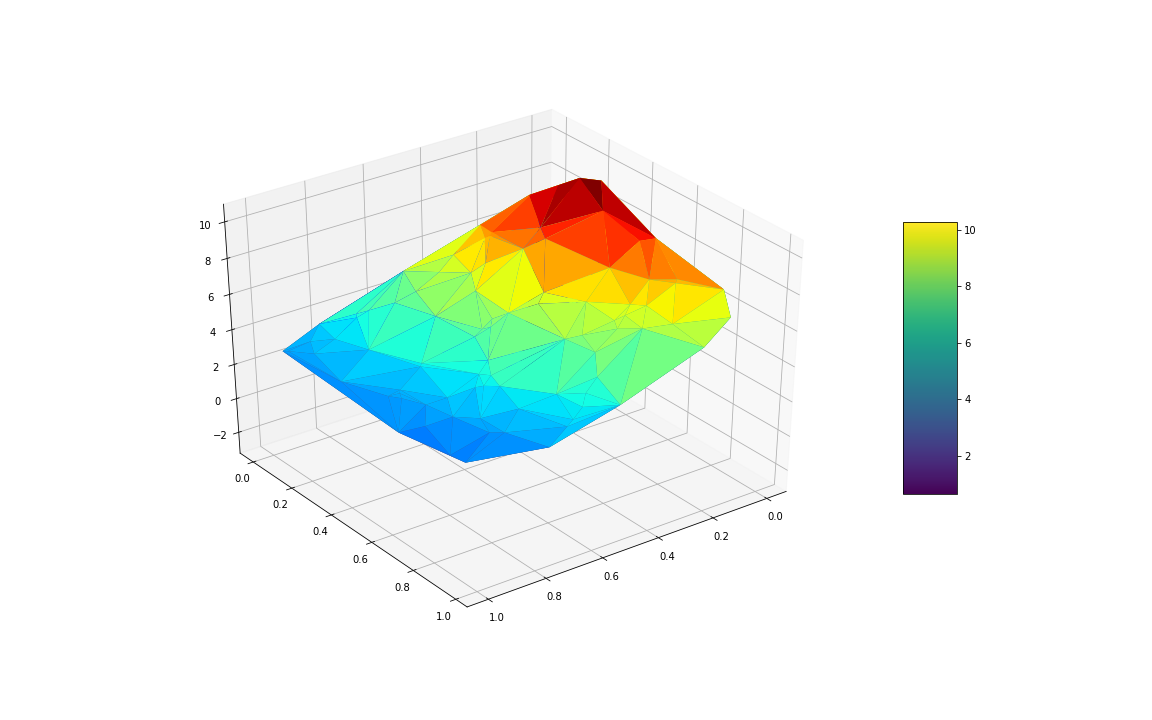

In [84]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

fig = plt.figure(figsize = (16, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['n1'], df['n2'], res, cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['n1'], df['n2'], res, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(30, 45)
plt.show()
 
# Other palette
ax.plot_trisurf(df['n1'], df['n2'], res, cmap=plt.cm.jet, linewidth=0.01)
plt.show()